In [53]:
#Adding project root to notebook search paths to utilize project-wide importing from utils.py and config.py
import sys
from pathlib import Path
source_path = Path.cwd().parent
sys.path.append(str(source_path))

In [54]:
#import statements
from utils import ingest_kaggle_data, one_hot_encode, list_column_types, impute_missing
from config import MODELS_PATH
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [55]:
#Load in data
handle = "anaghapaul/e-commerce-dataset"
df = ingest_kaggle_data(handle)
df.head()

Dataset URL: https://www.kaggle.com/datasets/anaghapaul/e-commerce-dataset


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [56]:
#Exploratory data analysis pre-modeling 
    #Missing values
print("Columns, types, and counts:")
print(df.info(), "\n")
print("Missing values per column:")
print(df.isnull().sum())

Columns, types, and counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   obj

In [57]:
#Getting column types
num_cols, binary_cols, multi_cat_cols = list_column_types(df)

<Axes: >

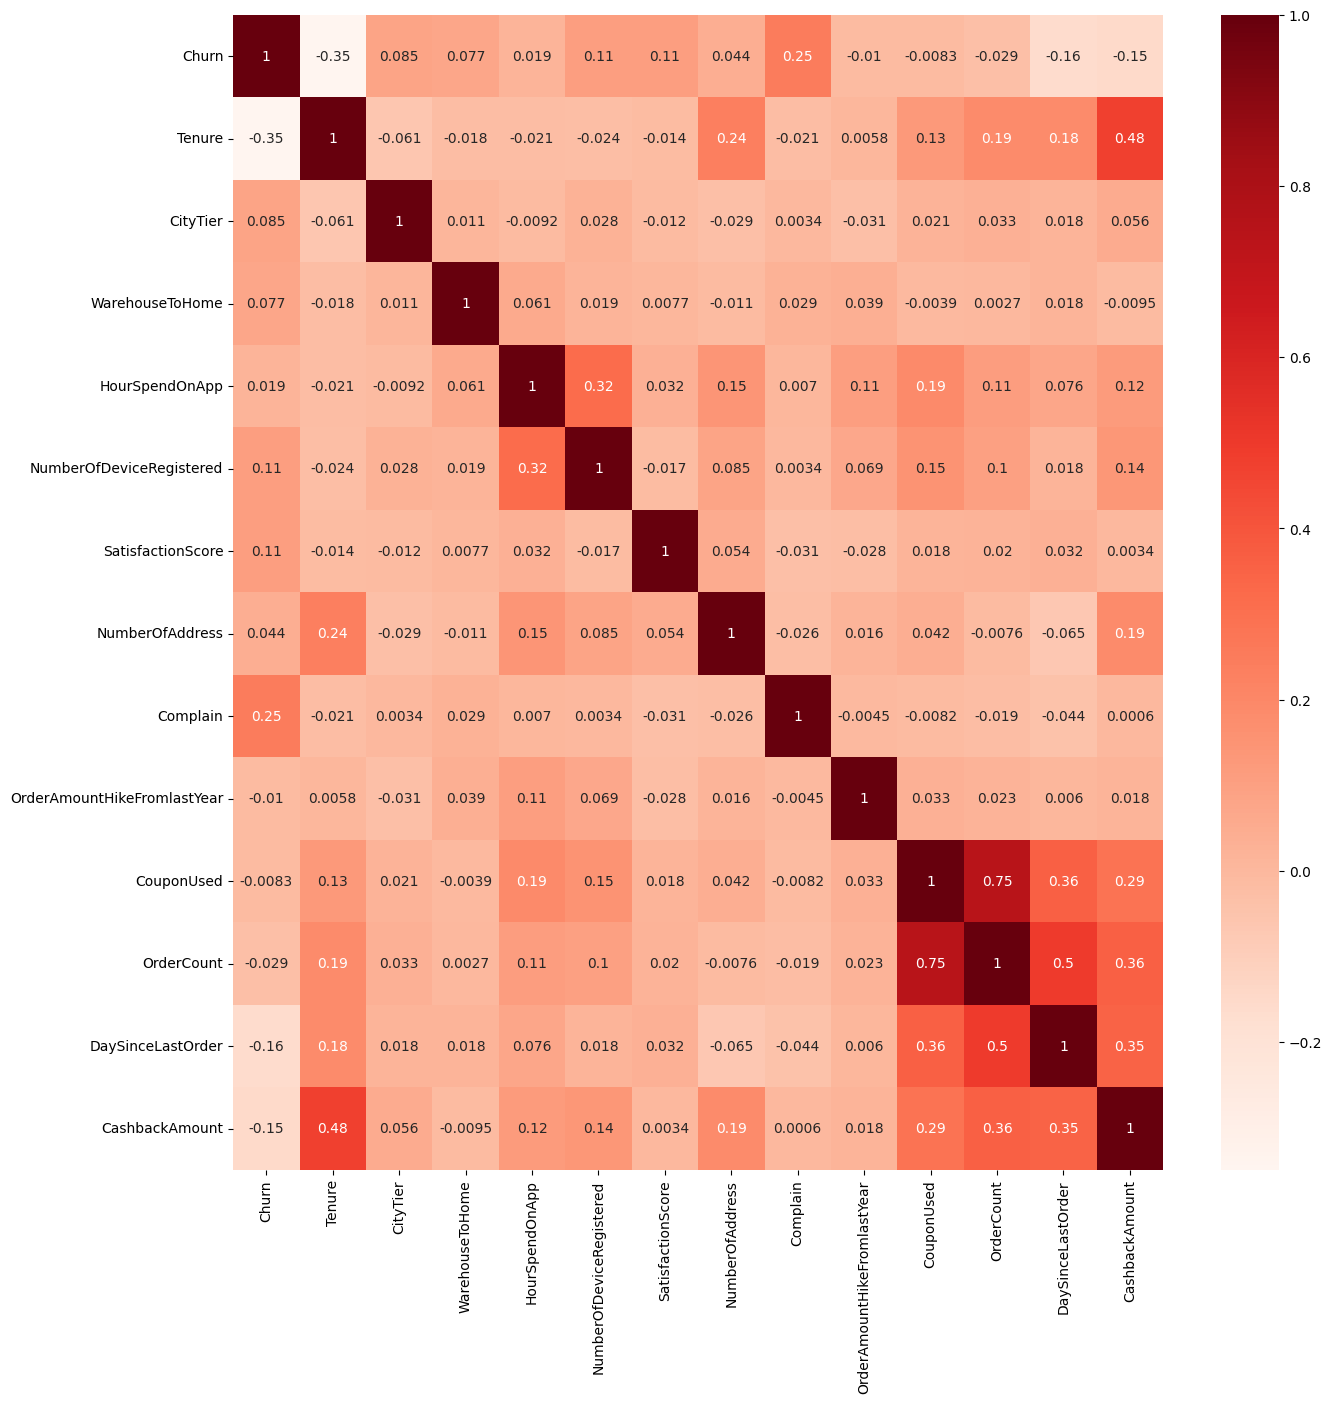

In [58]:
#Correlation analysis for most important features in churn
plt.figure(figsize = (15,15))
sns.heatmap(data = df.drop(columns = "CustomerID").corr(numeric_only = True), annot=True, cmap = "Reds")

Text(0.5, 1.0, 'Complaint rate by churn')

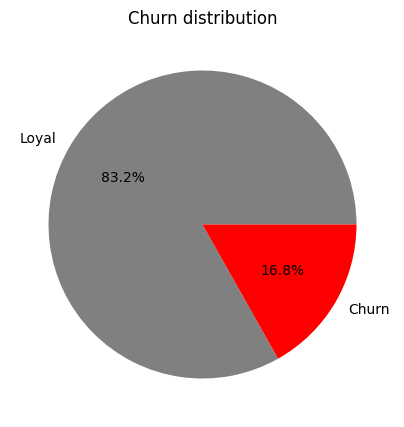

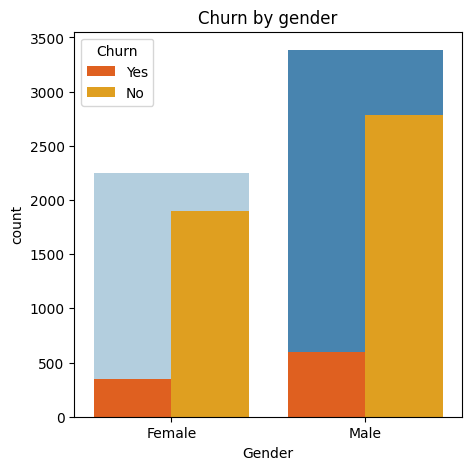

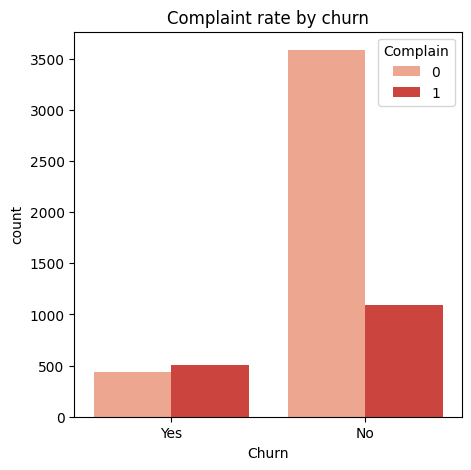

In [59]:
#Target (churn) analysis
df["Churn"] = df["Churn"].map({0: "No", 1: "Yes"})

    #Distribution of churn
plt.figure(figsize = (5,5))
plt.pie(x = df["Churn"].value_counts(), labels = ["Loyal", "Churn"], autopct = "%1.1f%%", colors = ["gray", "red"])
plt.title("Churn distribution")

    #Gender distribution and churn by gender
plt.figure(figsize = (5,5))
    #Repeatedly passing x feature as hue in order to use palatte parameter, which will soon require hue
sns.countplot(data = df, x = "Gender", hue = "Gender", palette = "Blues")
sns.countplot(data = df, x = "Gender", hue = "Churn", palette = "autumn")
plt.title("Churn by gender")

    #Complaints by churn
plt.figure(figsize = (5,5))
sns.countplot(data = df, x = "Churn", hue = "Complain", palette = "Reds")
plt.title("Complaint rate by churn")


<Axes: xlabel='Tenure', ylabel='DaySinceLastOrder'>

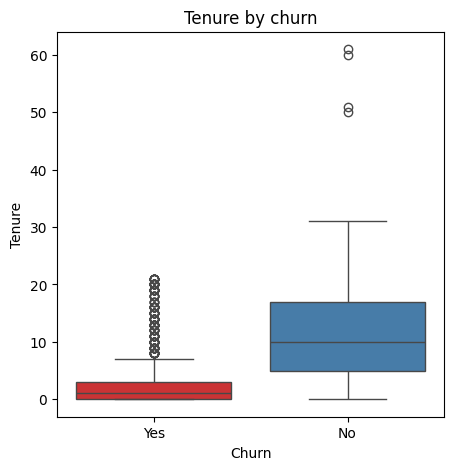

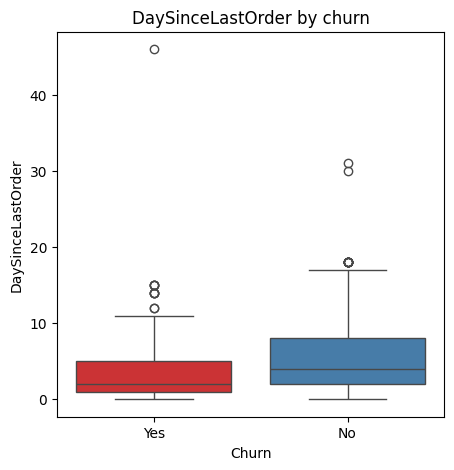

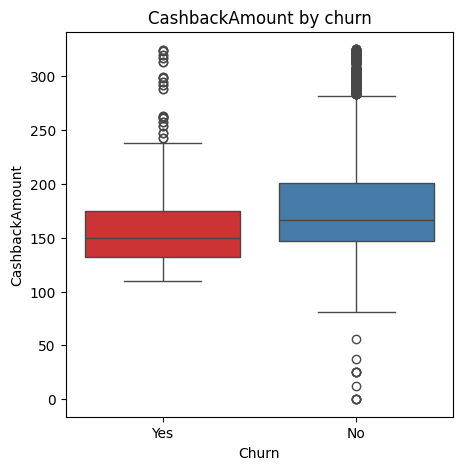

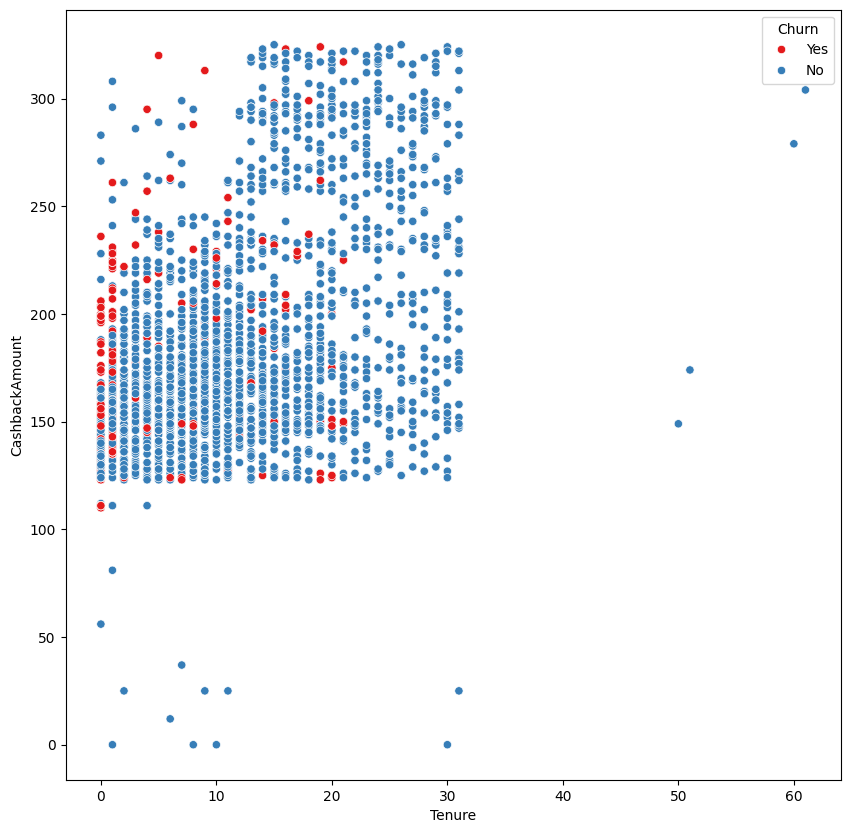

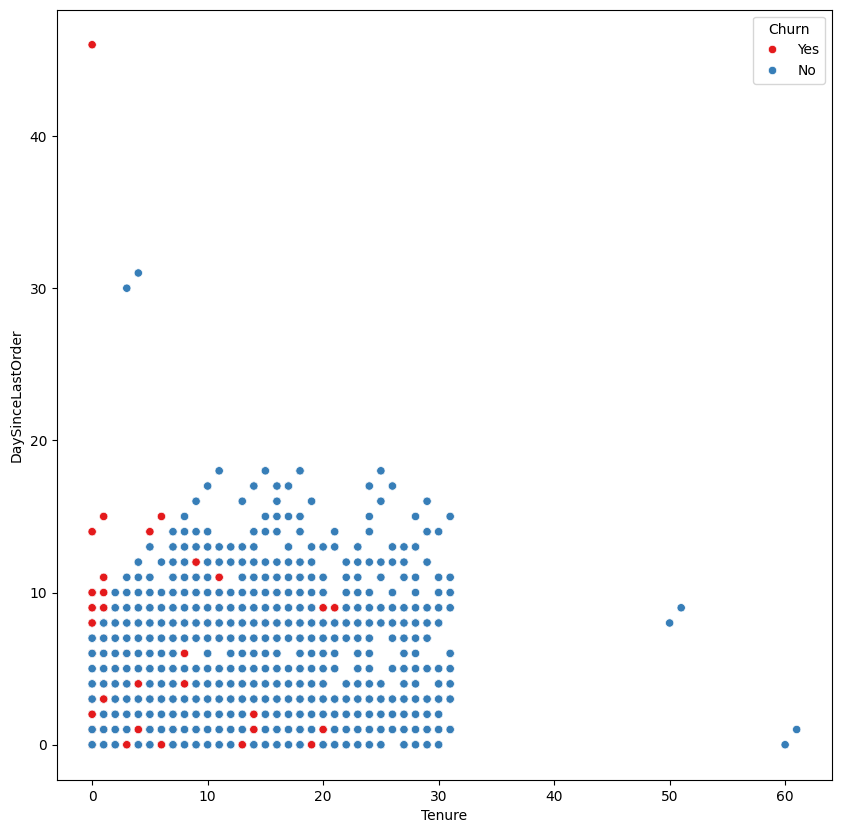

In [60]:
#Multivariate analysis
for strong_num_feature in ["Tenure", "DaySinceLastOrder", "CashbackAmount"]:
    plt.figure(figsize = (5, 5))
    sns.boxplot(data = df, x = "Churn", y = strong_num_feature, hue = "Churn", palette = "Set1")
    plt.title(f"{strong_num_feature} by churn")

plt.figure(figsize = (10,10))
sns.scatterplot(data = df, x = "Tenure", y = "CashbackAmount", hue = "Churn", palette = "Set1")
plt.figure(figsize = (10,10))
sns.scatterplot(data = df, x = "Tenure", y = "DaySinceLastOrder", hue = "Churn", palette = "Set1")

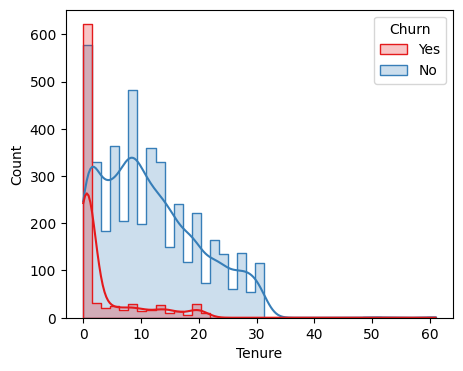

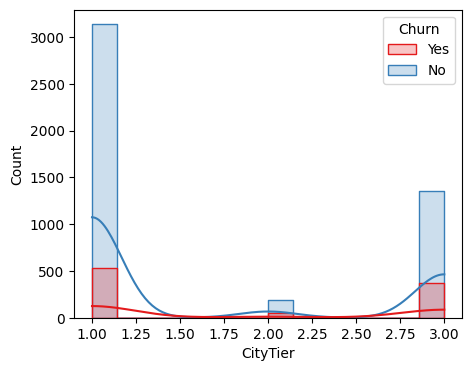

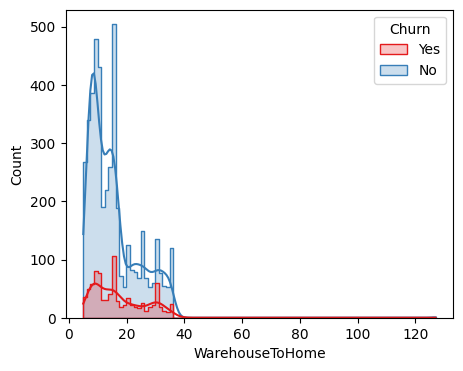

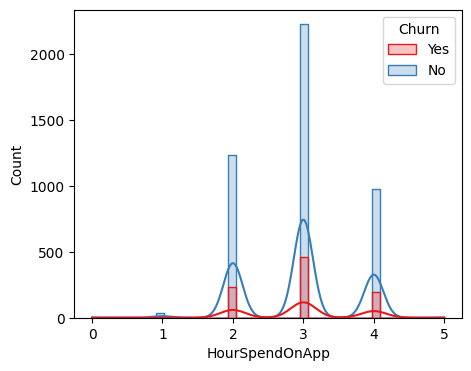

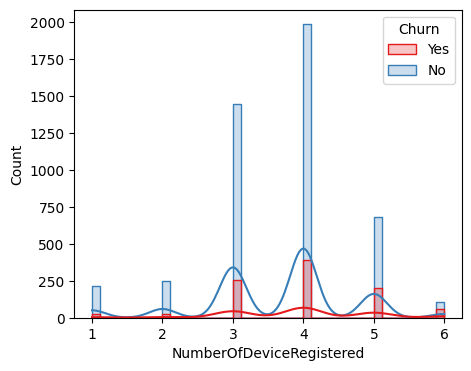

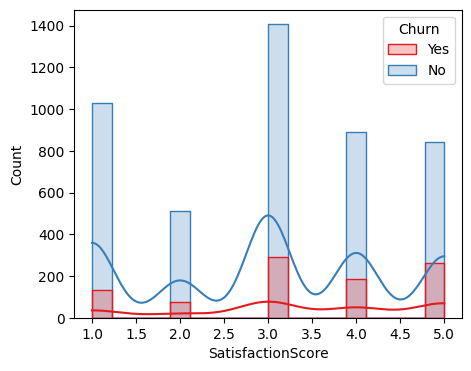

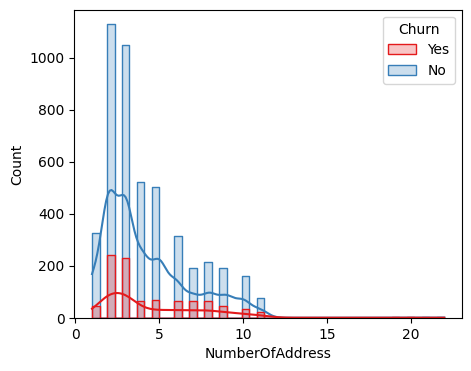

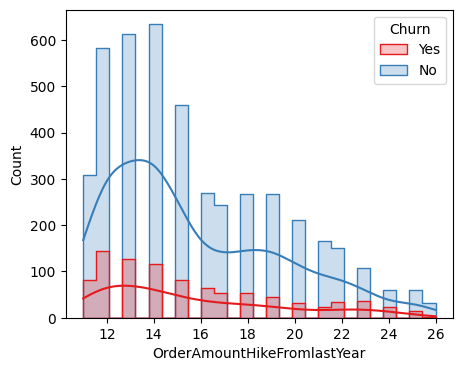

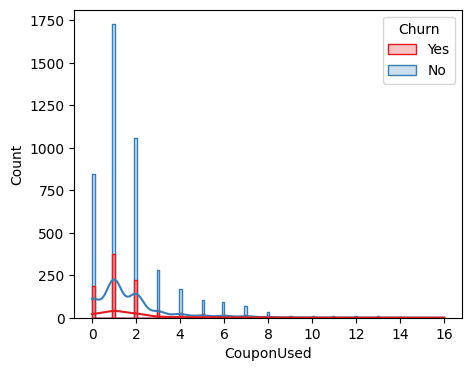

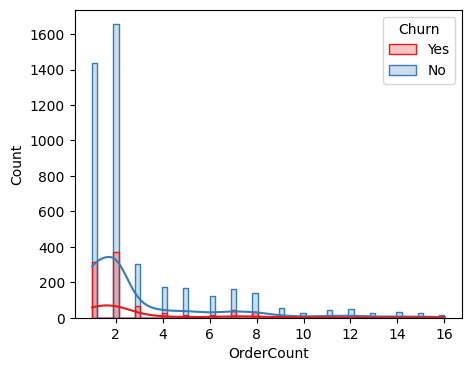

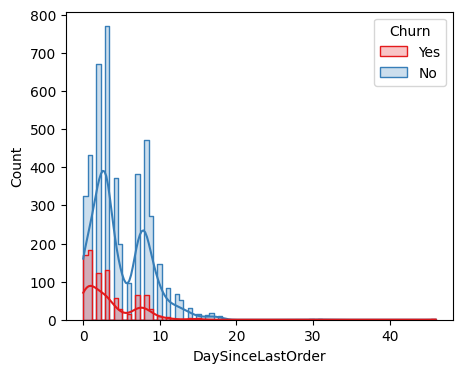

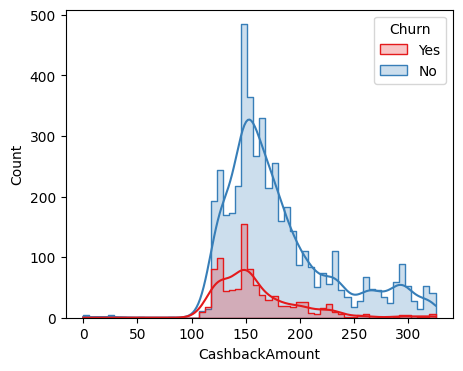

In [61]:
#Univariate analysis
for col in num_cols:
    if col != "CustomerID":
        plt.figure(figsize = (5, 4))
        sns.histplot(data = df, x = col, hue = "Churn", element = "step", kde = True, palette = "Set1")

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [62]:
#Preprocessing data for model
    #Handling missing values
df = impute_missing(df)

    #Dropping irrelevant columns
df = df.drop(columns = ["CustomerID"])

    #One-hot encoding categorical columns
df = one_hot_encode(df)

df.head()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Churn_1,Gender_Male,Complain_1
0,4.0,3.0,6.0,3.0,3.0,2.0,9.0,11.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,1
1,9.0,1.0,8.0,3.0,4.0,3.0,7.0,15.0,0.0,1.0,...,0,0,0,0,0,0,1,1,1,1
2,9.0,1.0,30.0,2.0,4.0,3.0,6.0,14.0,0.0,1.0,...,0,0,0,0,1,0,0,1,1,1
3,0.0,3.0,15.0,2.0,4.0,5.0,8.0,23.0,0.0,1.0,...,0,0,0,0,1,0,0,1,1,0
4,0.0,1.0,12.0,3.0,3.0,5.0,3.0,11.0,1.0,1.0,...,1,0,0,0,0,0,0,1,1,0


In [63]:
#Defining X and y
X = df.drop(columns = ["Churn_1"])
y = df["Churn_1"]

#Splitting the data for training, including passing the index for adding shuffled train and test predictions to the correct indices of the dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index, test_size = 0.3, stratify = y, random_state = 42)

In [64]:
#Instantiating and training the model
model = RandomForestClassifier(random_state=42)

param_grid = {
  'n_estimators': [100, 300],
  'max_depth': [5, 10, None],
  'class_weight': ['balanced', None]
}

grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, scoring = "f1")

grid.fit(X_train, y_train)
print("Best estimator:", grid.best_estimator_)

#Saving the trained model using joblib
model_file = MODELS_PATH.joinpath("rfc_churn.joblib")
joblib.dump(grid, model_file)

Best estimator: RandomForestClassifier(n_estimators=300, random_state=42)


['/Users/grantrwilliams/Library/Mobile Documents/com~apple~CloudDocs/VS Code/e-commerce_churn_pipeline/src/models/rfc_churn.joblib']

In [65]:
#Running predictions using the saved model
rfc = joblib.load(model_file)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

#Evaluating model performance
print("Train classification report:\n", classification_report(y_train, y_train_pred))
print("Test classification report:\n", classification_report(y_test, y_test_pred))

Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3277
           1       1.00      1.00      1.00       664

    accuracy                           1.00      3941
   macro avg       1.00      1.00      1.00      3941
weighted avg       1.00      1.00      1.00      3941

Test classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.95      0.81      0.87       284

    accuracy                           0.96      1689
   macro avg       0.95      0.90      0.92      1689
weighted avg       0.96      0.96      0.96      1689

